In [38]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm.notebook import tqdm, trange
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from model import SiameseNetwork

!nvidia-smi

Wed Mar 23 00:12:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 462.35       Driver Version: 462.35       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 306... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0    25W /  N/A |   4324MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    



In [3]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("RGB")
        img1 = img1.convert("RGB")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
        

In [4]:
train_folder_dataset = datasets.ImageFolder(root="./dataset/classification/train1000/")

In [5]:
transformation = transforms.Compose([
                                     transforms.ToTensor()
                                    ])
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=train_folder_dataset,
                                        transform=transformation)

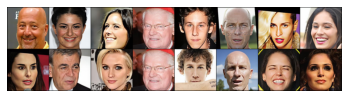

[1. 1. 1. 0. 0. 0. 1. 0.]


In [6]:
example_dl = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)

example_batch = next(iter(example_dl))


concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [6]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=4.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [13]:
model= SiameseNetwork(3)
model = model.to("cuda")
loss_fn = ContrastiveLoss()

loss_list = []


In [14]:
epochs = 200
train_loader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=128)
loop = trange(epochs)
optimizer = torch.optim.AdamW(model.parameters(),5e-4)

for epoch in loop:
    running_loss = 0
    for X1 ,X2 ,y in train_loader:
        X1, X2 , y = X1.to("cuda") ,X2.to("cuda") ,y.to("cuda")
        optimizer.zero_grad()
        out1, out2= model(X1, X2)
        loss = loss_fn(out1, out2, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss = running_loss/len(train_loader)
    loss_list.append(loss)
    loop.set_postfix(dict(loss = loss))

  0%|          | 0/200 [00:00<?, ?it/s]

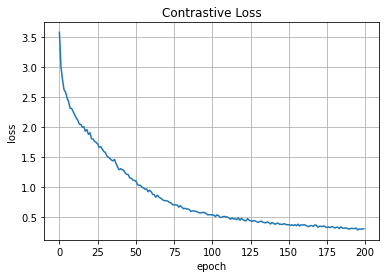

In [15]:
plt.plot(loss_list)
plt.title("Contrastive Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")

In [39]:
validation_folder_dataset = datasets.ImageFolder(root="./dataset/classification/test1000/")
validation_dataset = SiameseNetworkDataset(imageFolderDataset=validation_folder_dataset,
                                        transform=transformation)
val_loader = DataLoader(validation_dataset,
                        shuffle=True,
                        batch_size=256)
loss_fn = ContrastiveLoss()

with torch.no_grad():
    running_loss = 0
    for X1 ,X2 ,y in tqdm(val_loader):
        X1, X2 , y = X1.to("cuda") ,X2.to("cuda") ,y.to("cuda")
        out1, out2= model(X1, X2)
        loss = loss_fn(out1, out2, y)
        running_loss += loss.item()
        
    loss = running_loss/len(val_loader)
    
print(f"validation loss = {loss}")

  0%|          | 0/20 [00:00<?, ?it/s]

validation loss = 0.49004318863153457


In [40]:
train_loader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=128)
with torch.no_grad():
    running_loss = 0
    for X1 ,X2 ,y in tqdm(train_loader):
        X1, X2 , y = X1.to("cuda") ,X2.to("cuda") ,y.to("cuda")
        out1, out2= model(X1, X2)
        loss = loss_fn(out1, out2, y)
        running_loss += loss.item()
        
    loss = running_loss/len(train_loader)
    
print(f"training loss = {loss}")

  0%|          | 0/157 [00:00<?, ?it/s]

training loss = 0.3101087292288519


In [12]:
train_clf_dataset = datasets.ImageFolder(root="./dataset/classification/train1000/"
                                                 ,transform=transforms.ToTensor())
with torch.no_grad():
    outs=torch.zeros(len(train_clf_dataset),30)
    ys = np.zeros(len(train_clf_dataset))
    for i, (X, y) in tqdm(enumerate(train_clf_dataset)
                          ,total = len(train_clf_dataset)):
        X=torch.unsqueeze(X,0)
        X=X.to("cuda")
        out=model.forward_once(X)
        outs[i,:] = out.to("cpu")
        ys[i] = y
outs=outs.to("cpu")
outs=outs.numpy()
X_train = outs
y_train = ys

100%|██████████| 20000/20000 [00:57<00:00, 346.73it/s]


In [13]:
validation_folder_dataset = datasets.ImageFolder(root="./dataset/classification/test1000/"
                                                 ,transform=transforms.ToTensor())

In [16]:
with torch.no_grad():
    outs=torch.zeros(len(validation_folder_dataset),30)
    ys = np.zeros(len(validation_folder_dataset))
    for i, (X, y) in tqdm(enumerate(validation_folder_dataset)
                          ,total = len(validation_folder_dataset)):
        X=torch.unsqueeze(X,0)
        X=X.to("cuda")
        out=model.forward_once(X)
        outs[i,:] = out.to("cpu")
        ys[i] = y
outs=outs.to("cpu")
outs=outs.numpy()
X_test = outs
y_test = ys

100%|██████████| 5000/5000 [00:12<00:00, 398.16it/s]


In [17]:
clf = KNeighborsClassifier(n_neighbors = 16)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.0624

In [18]:
clf = SVC()
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.0652

In [19]:
idx = np.where(y_train <= 3 )

In [20]:
X_train_sub = X_train[idx[0],:]
y_train_sub = y_train[idx[0]]


In [21]:
idx = np.where(y_test <= 3 )
X_test_sub = X_test[idx[0],:]
y_test_sub = y_test[idx[0]]


In [22]:
clf = KNeighborsClassifier(n_neighbors = 16)
clf.fit(X_train_sub, y_train_sub)
print(f"test acc {clf.score(X_test_sub,y_test_sub)}, training acc {clf.score(X_train_sub,y_train_sub)}")

test acc 0.7, training acc 0.9125


In [23]:
clf = SVC()
clf.fit(X_train_sub, y_train_sub)
print(f"test acc {clf.score(X_test_sub,y_test_sub)}, training acc {clf.score(X_train_sub,y_train_sub)}")

test acc 0.85, training acc 0.9375


In [24]:
y_pred = clf.predict(X_test_sub)
print(classification_report(y_test_sub,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         5
         1.0       0.83      1.00      0.91         5
         2.0       0.67      0.80      0.73         5
         3.0       1.00      0.60      0.75         5

    accuracy                           0.85        20
   macro avg       0.88      0.85      0.85        20
weighted avg       0.88      0.85      0.85        20



Text(0.5, 1.0, 'Confusion Matrix')

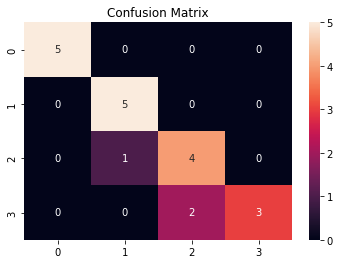

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test_sub,y_pred),annot=True)
plt.title("Confusion Matrix")